In [6]:
from tl_tools import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pandas as pd
from tensorflow.keras.applications import ResNet50V2

In [7]:
setup_mixed_precision()
train_dir = '/Users/pimpijnenburg/Desktop/Thesis/USTC_SmokeRS_dataset/data/USTC_SmokeRS/processed/train'

train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True ,vertical_flip=True)
train =train_datagen.flow_from_directory(train_dir, color_mode= 'rgb', batch_size = 16, shuffle= True, seed = 1, target_size=(256, 256))


X_train, y_train, X_val, y_val = train_val_split(train, val_split= 0.3)

Mixed precision policy set to: mixed_float16

Found 4980 images belonging to 6 classes.
Number of batches in the training data: 312
Batch size of a single batch 16
Number of samples in the training dataset 4980

Number of training data batches with val split of 0.3: 219
Number of validation data batches: 93

Shape of image training set: (3504, 256, 256, 3)
Shape of image validation set: (1476, 256, 256, 3)

Shape of label training set: (3504, 6)
Shape of label validation set: (1476, 6)


In [8]:
test_dir = '/Users/pimpijnenburg/Desktop/Thesis/USTC_SmokeRS_dataset/data/USTC_SmokeRS/processed/test'
test_datagen = ImageDataGenerator(rescale=1./255)
test = test_datagen.flow_from_directory(test_dir, color_mode= 'rgb', batch_size = 16, shuffle= True, seed = 1, target_size=(256, 256))
X_test, y_test = test_splits(test)

Found 1245 images belonging to 6 classes.
Number of batches in the test data: 78
Batch size of a single batch 16
Number of samples in the test dataset 1245

Shape of image test set: (1245, 256, 256, 3)

Shape of label test set: (1245, 6)


In [9]:
pooling = 'avg'
resnet50v2 = ResNet50V2(weights= 'imagenet',include_top= False, input_shape= (256, 256, 3), pooling = pooling)
resnet50v2.trainable = False

model = fc_layers(resnet50v2, name = 'resnet50v2')

In [10]:
model.compile(optimizer=Adam(learning_rate = 0.001, clipnorm= 1.0),
                     loss='categorical_crossentropy', 
                     metrics=['accuracy', 'F1Score'])

early_stopping = EarlyStopping(monitor='val_loss', patience=15,restore_best_weights=True, start_from_epoch=20)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-6)

history =  model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, verbose=1, 
                            callbacks= [early_stopping, reduce_lr])

Epoch 1/50


2024-10-28 12:27:04.100999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


110/110 ━━━━━━━━━━━━━━━━━━━━ 37s 279ms/step - F1Score: 0.4484 - accuracy: 0.4577 - loss: 1.5840 - val_F1Score: 0.7104 - val_accuracy: 0.7202 - val_loss: 0.7744 - learning_rate: 0.0010
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 26s 241ms/step - F1Score: 0.7256 - accuracy: 0.7299 - loss: 0.7697 - val_F1Score: 0.7625 - val_accuracy: 0.7683 - val_loss: 0.6729 - learning_rate: 0.0010
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 26s 241ms/step - F1Score: 0.7984 - accuracy: 0.8018 - loss: 0.5850 - val_F1Score: 0.8064 - val_accuracy: 0.8069 - val_loss: 0.5486 - learning_rate: 0.0010
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 26s 241ms/step - F1Score: 0.8284 - accuracy: 0.8313 - loss: 0.5120 - val_F1Score: 0.8215 - val_accuracy: 0.8218 - val_loss: 0.4913 - learning_rate: 0.0010
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 26s 241ms/step - F1Score: 0.8623 - accuracy: 0.8643 - loss: 0.4118 - val_F1Score: 0.8295 - val_accuracy: 0.8313 - val_loss: 0.4935 - learning_rate: 0.0010
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━

In [11]:
pred = tf.argmax(model.predict(X_test), axis = 1).numpy()
y_true = tf.argmax(y_test, axis=1).numpy()

39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 213ms/step


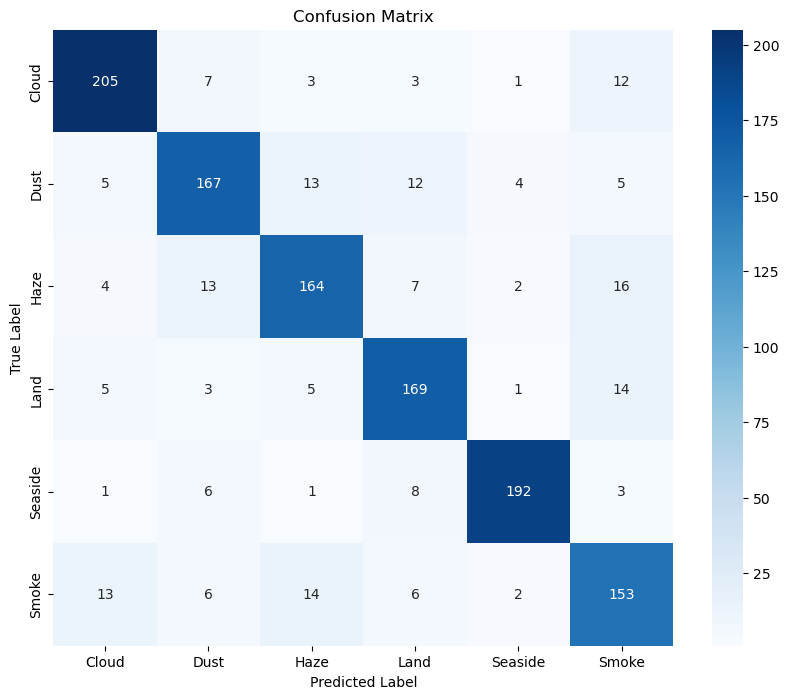

In [12]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

class_labels = list(test.class_indices.keys())
confusion_matrix = confusion_matrix(pred, y_true)


plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [13]:
n_classes = len(class_labels)
FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)
FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
TP = np.diag(confusion_matrix)
TN = confusion_matrix.sum() - (FP + FN + TP)

metrics = ['Precision', 'Recall', 'F1-score', 'False Negative Rate']

df_metrics = pd.DataFrame(index=metrics, columns=class_labels)

for i in range(n_classes):
    df_metrics.iloc[0, i] = TP[i] / (TP[i] + FP[i])
    df_metrics.iloc[1, i] = TP[i] / (TP[i] + FN[i])
    df_metrics.iloc[2, i] = 2 * TP[i] / (2 * TP[i] + FP[i] + FN[i])
    df_metrics.iloc[3, i] = FN[i] / (FN[i] + TP[i])  # False Negative Rate

def round_fn(input): 
    return round(input, 4)

df_metrics = df_metrics.map(round_fn)
df_metrics

,Cloud,Dust,Haze,Land,Seaside,Smoke
Precision,0.8798,0.8267,0.8200,0.8244,0.9505,0.7537
Recall,0.8874,0.8107,0.7961,0.8579,0.9100,0.7887
F1-score,0.8836,0.8186,0.8079,0.8408,0.9298,0.7708
False Negative Rate,0.1126,0.1893,0.2039,0.1421,0.0900,0.2113


In [14]:
from sklearn.metrics import accuracy_score

print(f'Accuracy Score: {accuracy_score(pred, y_true):.4f}')
for index, row in df_metrics.iterrows(): 
    row_mean = row.mean()
    print(f'Average {index} Score: {row_mean:.4f}')

Accuracy Score: 0.8434
Average Precision Score: 0.8425
Average Recall Score: 0.8418
Average F1-score Score: 0.8419
Average False Negative Rate Score: 0.1582


In [17]:
feature_extractor = Model(inputs=model.input, outputs=model.get_layer('avg_pool').output)
feature_extractor_pred = feature_extractor.predict(X_test)

39/39 ━━━━━━━━━━━━━━━━━━━━ 12s 238ms/step


In [18]:
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
feature_extractor_pred = scaler.fit_transform(feature_extractor_pred)
feature_extractor_df = pd.DataFrame(feature_extractor_pred)
y_true_series = pd.Series(y_true)

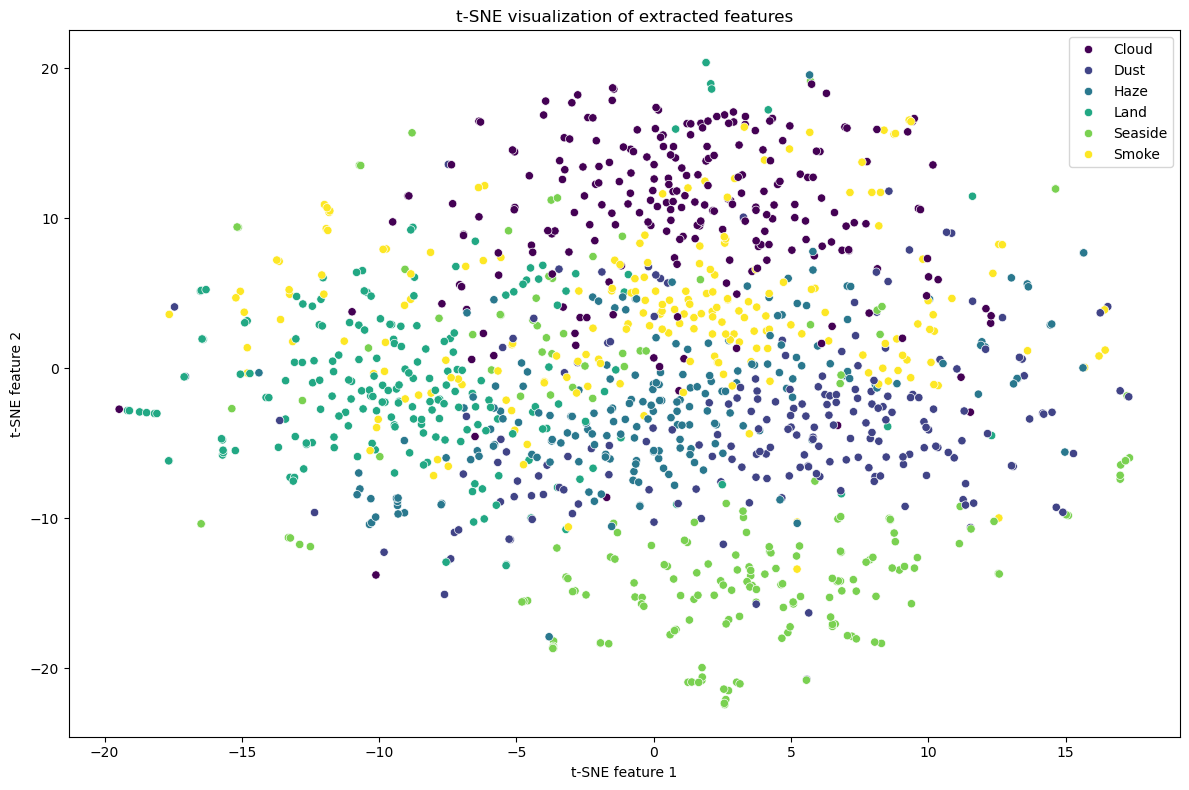

In [19]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components = 2, random_state= 1, perplexity= 30, max_iter = 1000)
X_tsne_2d = tsne.fit_transform(feature_extractor_df)

plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(x=X_tsne_2d[:, 0], y=X_tsne_2d[:, 1], hue=y_true, palette='viridis')
label_dict = {i: label for i, label in enumerate(class_labels)}

new_labels = [label_dict[int(item.get_text())] for item in scatter.legend_.texts]
for t, l in zip(scatter.legend_.texts, new_labels):
    t.set_text(l)

plt.title('t-SNE visualization of extracted features')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.tight_layout()
plt.show()

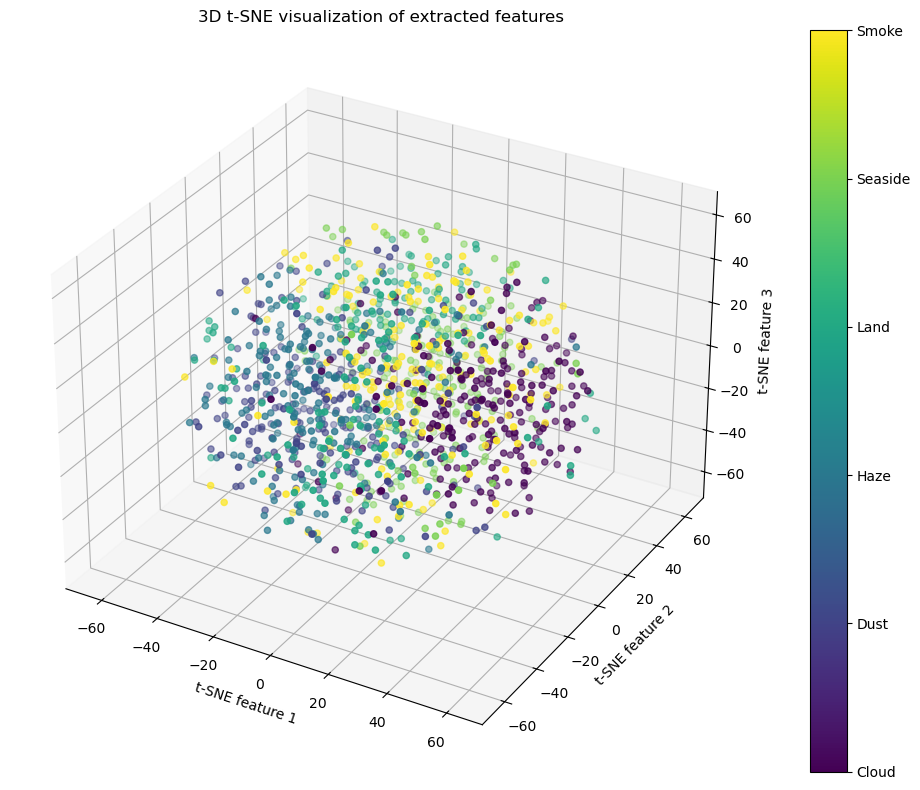

In [20]:
tsne = TSNE(n_components=3, random_state=1, perplexity=30, max_iter =1000)
X_tsne_3d = tsne.fit_transform(feature_extractor_df)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_tsne_3d[:, 0], X_tsne_3d[:, 1], X_tsne_3d[:, 2], c=y_true, cmap='viridis')
ax.set_xlabel('t-SNE feature 1')
ax.set_ylabel('t-SNE feature 2')
ax.set_zlabel('t-SNE feature 3')
ax.set_title('3D t-SNE visualization of extracted features')

cbar = plt.colorbar(scatter)
cbar.set_ticks(range(len(class_labels)))
cbar.set_ticklabels(class_labels)

plt.tight_layout()
plt.show()

In [21]:
import plotly.express as px

df = pd.DataFrame({
    'tsne-1': X_tsne_3d[:, 0],
    'tsne-2': X_tsne_3d[:, 1],
    'tsne-3': X_tsne_3d[:, 2],
    'class': [class_labels[i] for i in y_true]
})

fig = px.scatter_3d(df, x='tsne-1', y='tsne-2', z='tsne-3',
                    color='class', 
                    title='Interactive 3D t-SNE visualization of extracted features',
                    labels={'tsne-1': 't-SNE feature 1', 
                            'tsne-2': 't-SNE feature 2', 
                            'tsne-3': 't-SNE feature 3'},
                    hover_data=['class'])

fig.update_traces(marker=dict(size=5))
fig.update_layout(legend=dict(itemsizing='constant'))
fig.show()